# **PrediCare - AI Breast Cancer Diagnosis**
## **Part 2**

**Feature Extraction** - This section processes the balanced dataset (normal, benign, malignant) by applying local binary pattern (LBP) and histogram of gradient (HOG) algorithms. LBP and HOG extract essential features and textures from ultrasound images, offering detailed insights into their characteristics.

**Image Segmentation** - Here, the U-Net CNN architecture is utilized for image segmentation. The original image, along with LBP and HOG transformations, serves as input variables. Ground truth masks from the dataset guide U-Net training, enabling the creation of masks highlighting specific regions of interest within the images.

**Image Classification** - In this section, image classification is conducted using transfer learning with ResNet50 as the backbone. Inputs include the original images, LBP- and HOG-images, and predicted masks from U-Net, contribute to training. ResNet50's efficiency in complex image classification tasks enhances the model's ability to categorize ultrasound images into normal, benign, and malignant classes.

In [ ]:
# Import libraries
import os
import cv2
import pandas as pd
import numpy as np
from skimage import io, feature, color, exposure
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import ndimage

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import predicare_functions

### **Feature Extraction**

In this part, we read the balanced dataset created in the "predicare_part_1" notebook. To understand the texture and details of the ultrasound images, we use methods called Local Binary Pattern (LBP) and Histogram of Oriented Gradients (HOG).

LBP is good at finding patterns and textures in small areas of an image, which helps us notice intricate details in ultrasound images. HOG, on the other hand, focuses on figuring out how the intensity (brightness) changes across the image.

We label the dataset: normal as 0, benign as 1, and malignant as 2 to make it easier to categorize. We choose these methods because they are good at showing the details in medical images, helping us see patterns related to different breast conditions in ultrasound pictures.



In [ ]:
# Provide the path with the balanced data set
data_dir_balanced = '/path/to/balanced_data_set/'

# Read the images, masks, and labels and store them in lists
images, masks, labels = read_balanced_data(data_dir_balanced)

In [ ]:
# Computing the LBP-images for the origin images
lbps = compute_lbps(images)

# Computing the HOG-images for the origin images
hogs = compute_hogs(images)

In [ ]:
# Creating a pandas dataframe from the generated lists images, masks, lbps, hogs, and labels
df = pd.DataFrame({'images': images, 'masks': masks, 'lbps': lbps, 'hogs': hogs, 'labels': labels})

# Performing a train-test data set split on the created pandas dataframe
train_data, test_data = train_test_split(df, test_size = 0.2, random_state=42, stratify=df['labels'])

# Reset the index after the train-test split
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

print('Shape of the overall data set: ', df.shape)
print('Shape of the train data set: ', train_data.shape)
print('Shape of the test data set: ', test_data.shape)

Shape of the overall data set:  (894, 5)
Shape of the train data set:  (715, 5)
Shape of the test data set:  (179, 5)


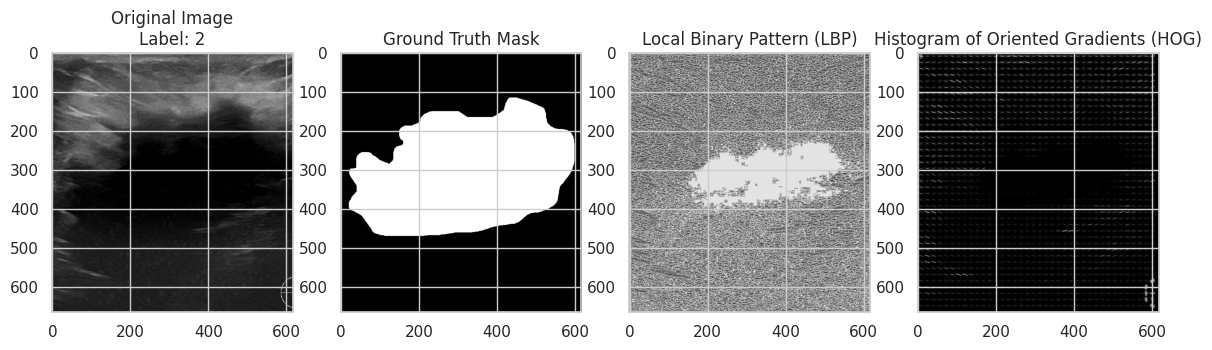

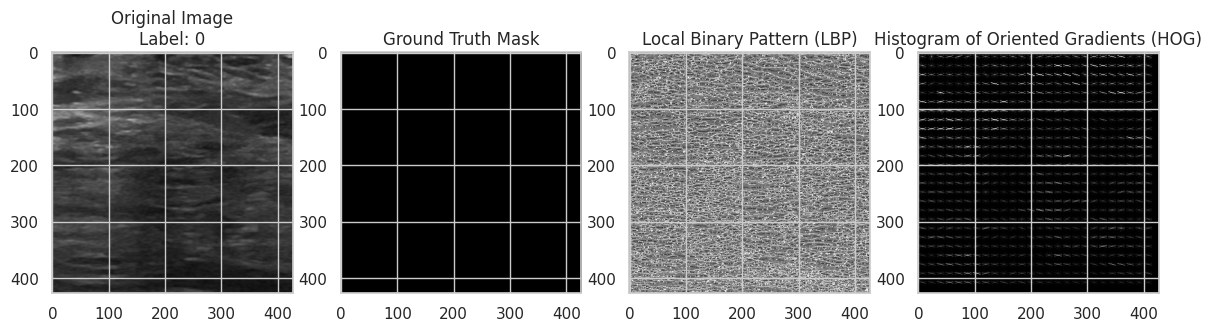

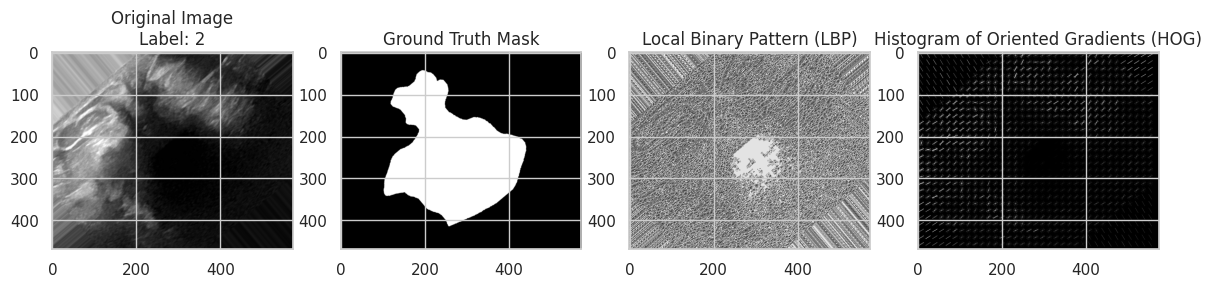

In [ ]:
# Visualize some origin images, ground truth masks, LBP-images, and HOG-images on the train data set
num_samples_to_visualize = 3
visualize_images(train_data['images'][:num_samples_to_visualize],
                 train_data['masks'][:num_samples_to_visualize],
                 train_data['lbps'][:num_samples_to_visualize],
                 train_data['hogs'][:num_samples_to_visualize],
                 train_data['labels'][:num_samples_to_visualize])


In [ ]:
# Preprocessing the train and test data set and separating the variables (origin image, LBP-image, HOG-image), masks (target in segmentation task), and labels (target in classification task).
# All images are resized to (128, 128) and transformed to numpy arrays

X_train_image, X_train_lbp, X_train_hog, train_masks, train_labels = preprocess_images_unet(train_data)

X_test_image, X_test_lbp, X_test_hog, test_masks, test_labels = preprocess_images_unet(test_data)


print(f"Shape of the Origin Images:")
print(f"  - Train Data: {X_train_image.shape}")
print(f"  - Test Data: {X_test_image.shape}\n")

print(f"Shape of the LBP Images:")
print(f"  - Train Data: {X_train_lbp.shape}")
print(f"  - Test Data: {X_test_lbp.shape}\n")

print(f"Shape of the HOG Images:")
print(f"  - Train Data: {X_train_hog.shape}")
print(f"  - Test Data: {X_test_hog.shape}\n")

print(f"Shape of the Masks:")
print(f"  - Train Data: {train_masks.shape}")
print(f"  - Test Data: {test_masks.shape}\n")

print(f"Shape of the Labels:")
print(f"  - Train Data: {train_labels.shape}")
print(f"  - Test Data: {test_labels.shape}")

<ipython-input-4-79f22a9448e9>:116: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  masks = np.zeros((len(data_set), height, width, 1), dtype=np.bool)


Shape of the Origin Images:
  - Train Data: (715, 128, 128, 3)
  - Test Data: (179, 128, 128, 3)

Shape of the LBP Images:
  - Train Data: (715, 128, 128, 1)
  - Test Data: (179, 128, 128, 1)

Shape of the HOG Images:
  - Train Data: (715, 128, 128, 1)
  - Test Data: (179, 128, 128, 1)

Shape of the Masks:
  - Train Data: (715, 128, 128, 1)
  - Test Data: (179, 128, 128, 1)

Shape of the Labels:
  - Train Data: (715,)
  - Test Data: (179,)


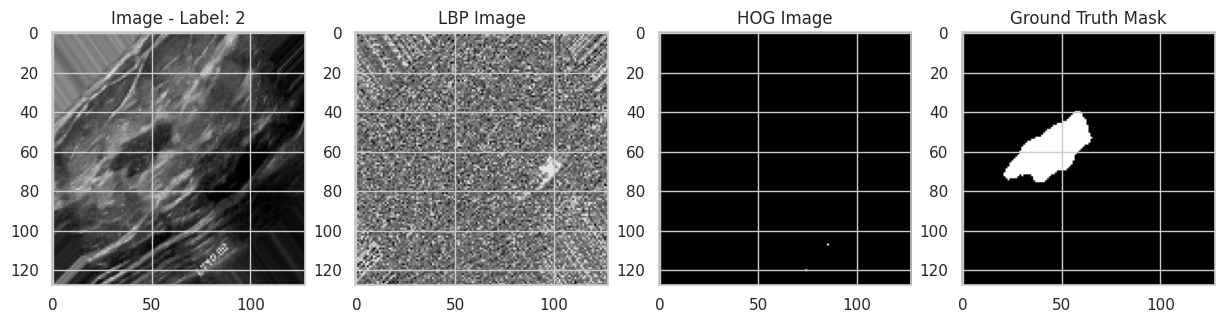

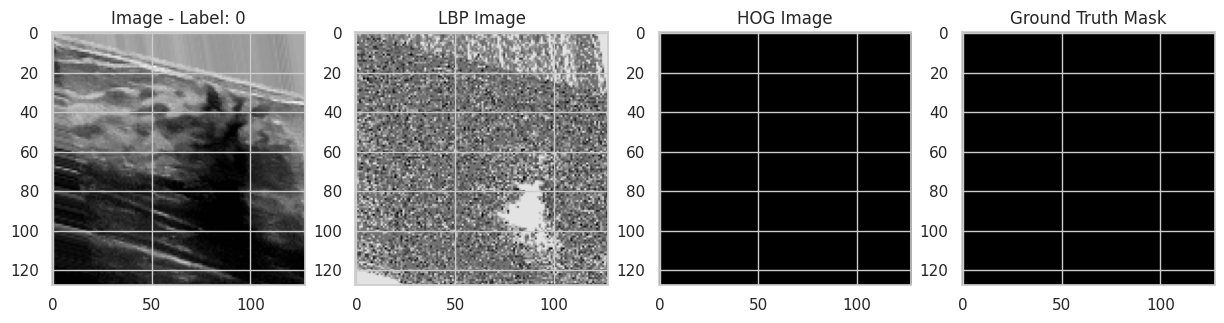

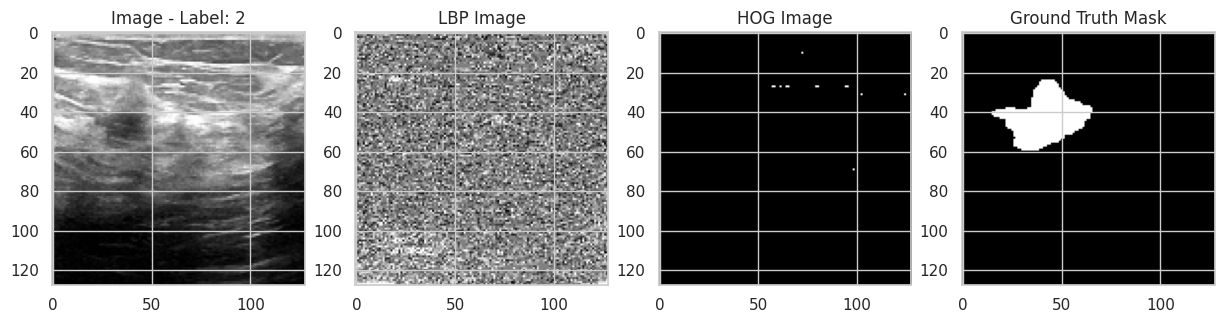

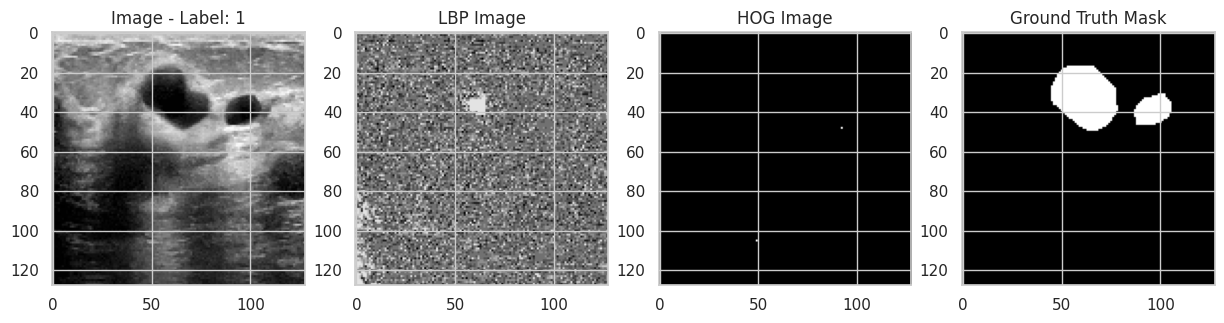

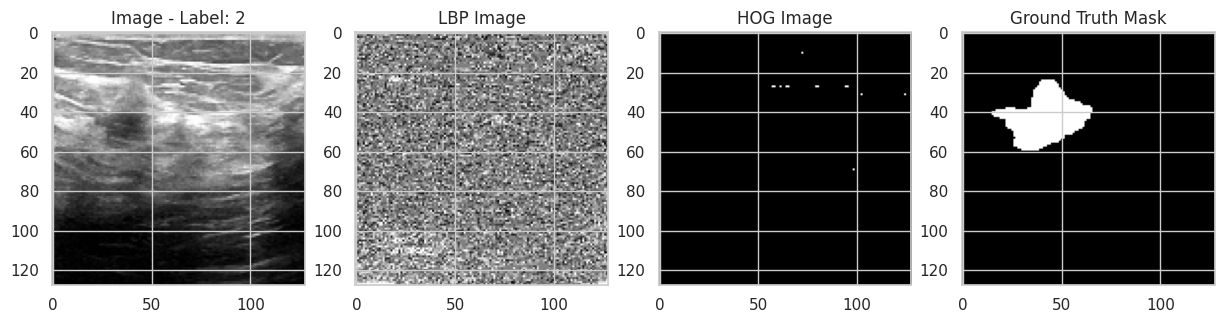

In [ ]:
# Visualize some origin images, masks, LBP-images, and HOG-images on the test data set after transforming into numpy arrays
visualize_images_nparray(X_test_image, X_test_lbp, X_test_hog, test_masks, test_labels, num_samples=5)


### **Image Segmentation with U-net architecture**


From a practical standpoint, medical specialists typically examine ultrasound images of the breast to identify the presence of nodes or tumors. The shape of the mass serves as a crucial characteristic in distinguishing whether the node or tumor is benign or malignant. In real-world scenarios, only the original ultrasound image is available, lacking a corresponding mask. Thus, the determination of whether an image falls into the "normal," "benign," or "malignant" class relies on the analysis of this original image.

To bridge this gap, image segmentation is introduced as an intermediary step. This process involves creating a mask that highlights the node or tumor, revealing its distinct shape. The provided dataset includes ground truth masks for each image, serving as targets to train a model based on the U-Net architecture. U-Net is a convolutional neural network commonly used for image segmentation tasks due to its ability to capture intricate details.

For U-Net training, the original images, along with LBP (Local Binary Pattern) and HOG (Histogram of Oriented Gradients) transformed images, are employed as inputs. These feature extraction methods, LBP and HOG, contribute additional information about textural patterns, enhancing the model's ability to discern important features in ultrasound images.

To evaluate the effectiveness of the U-Net model, the Intersection over Union (IoU) metric is utilized. IoU measures the overlap between the predicted mask and the ground truth mask, providing a quantitative assessment of segmentation accuracy.



In [ ]:
# Defining input layers for the U-net and convert them to a floating numbers
width, height, channels = X_train_image.shape[1:]

inputs_image = tf.keras.layers.Input((width, height, channels))
inputs_lbp = tf.keras.layers.Input((width, height, 1))
inputs_hog = tf.keras.layers.Input((width, height, 1))
combined_inputs = tf.keras.layers.Concatenate(axis=-1)([inputs_image, inputs_lbp, inputs_hog])

s = tf.keras.layers.Lambda(lambda x: x/255)(combined_inputs)

In [ ]:
# Defining the U-net architecture

# Contracting Path/Encoder
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(c5)

# Expansive Path/Decoder
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides = (2,2), padding = 'same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides = (2,2), padding = 'same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides = (2,2), padding = 'same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides = (2,2), padding = 'same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis =3)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)


In [ ]:
# Compiling an summarizing the U-net model
unet = tf.keras.Model(inputs=[inputs_image, inputs_lbp, inputs_hog], outputs=[outputs])
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])
unet.summary()

In [ ]:
# Defining callbacks to save the best model
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_unet_model.h5', verbose = 1, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
    ]

In [ ]:
# Defining hyperparameters and train the U-net model
batch_size = 8
learning_rate = 0.0001
epochs = 100

results = unet.fit([X_train_image,
                    X_train_lbp,
                    X_train_hog],
                    train_masks,
                    validation_split=0.1,
                    batch_size=batch_size,
                    epochs = epochs,
                    callbacks=callbacks)

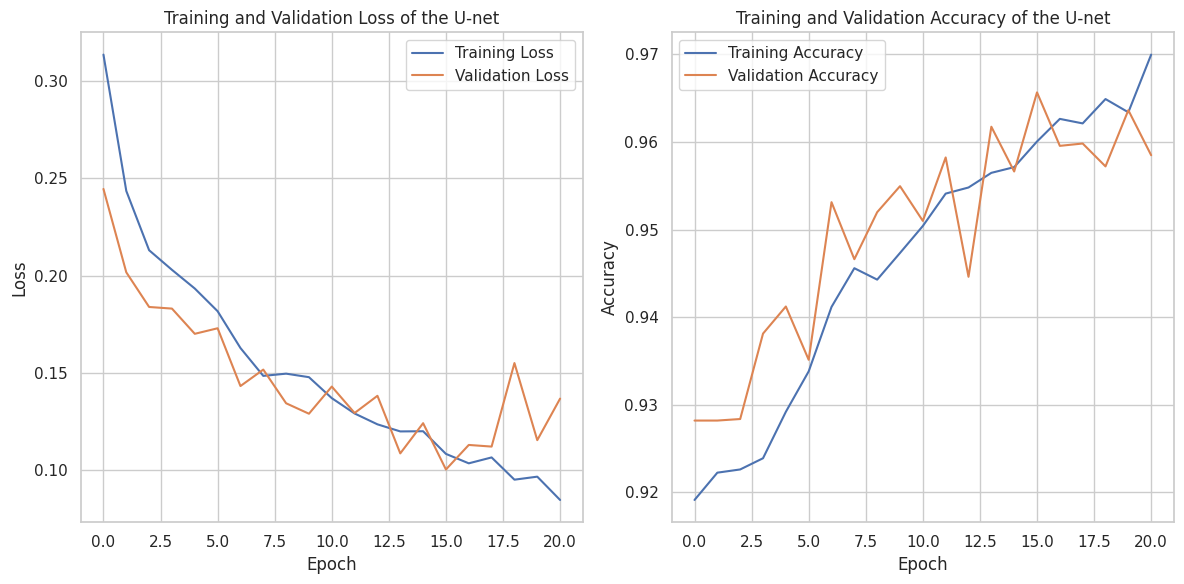

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(results.history['loss'], label='Training Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss of the U-net')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(results.history['accuracy'], label='Training Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy of the U-net')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Predicting the masks with the trained U-net model on the train and test data set
preds_train = unet.predict([X_train_image, X_train_lbp, X_train_hog], verbose =1)
preds_test = unet.predict([X_test_image, X_test_lbp, X_test_hog], verbose =1)

# Threshold the predicted mask to create binary masks
preds_train_mask = (preds_train > 0.5).astype(np.uint8)
preds_test_mask = (preds_test > 0.5).astype(np.uint8)

6/6 [==============================] - 6s 962ms/step


In [ ]:
# Calculate evaluation metrics IoU (Intersection over Union) on the test data set
iou = []
for i in range(len(X_test_image)):
    iou.append(tf.keras.metrics.MeanIoU(num_classes=2)(test_masks[i], preds_test_mask[i]).numpy())

# Calculate the average metrics
average_iou = np.mean(iou)

# Print the average metrics
print(f'Average IoU: {average_iou}')

Average IoU: 0.7733680009841919


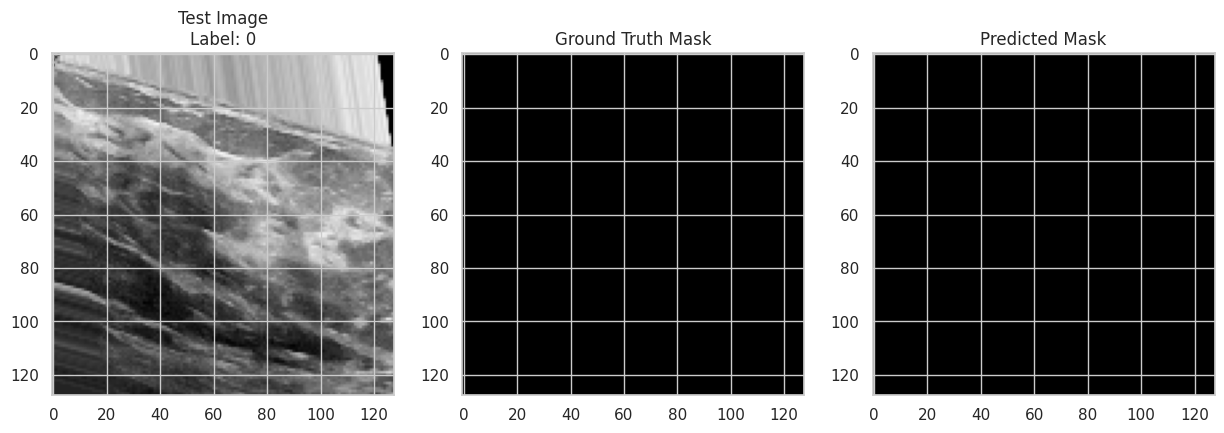

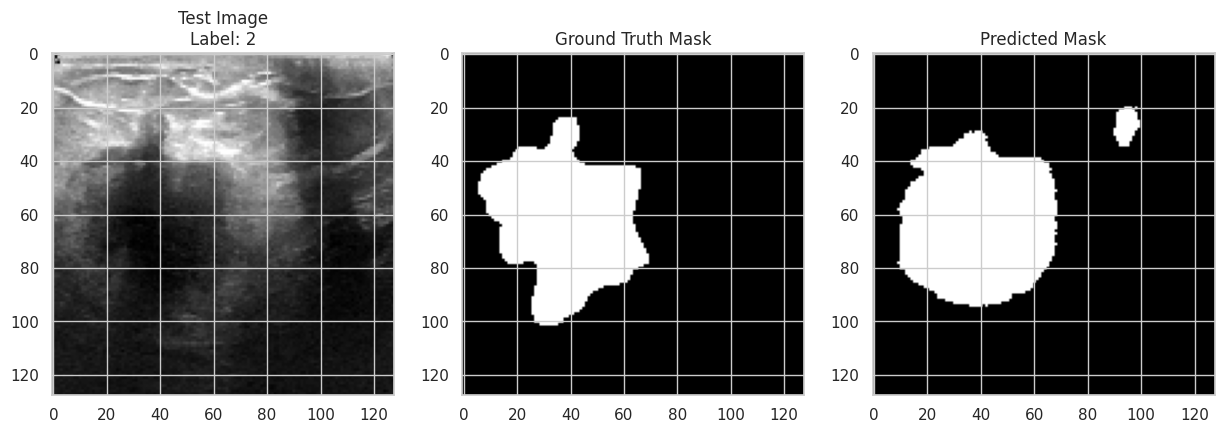

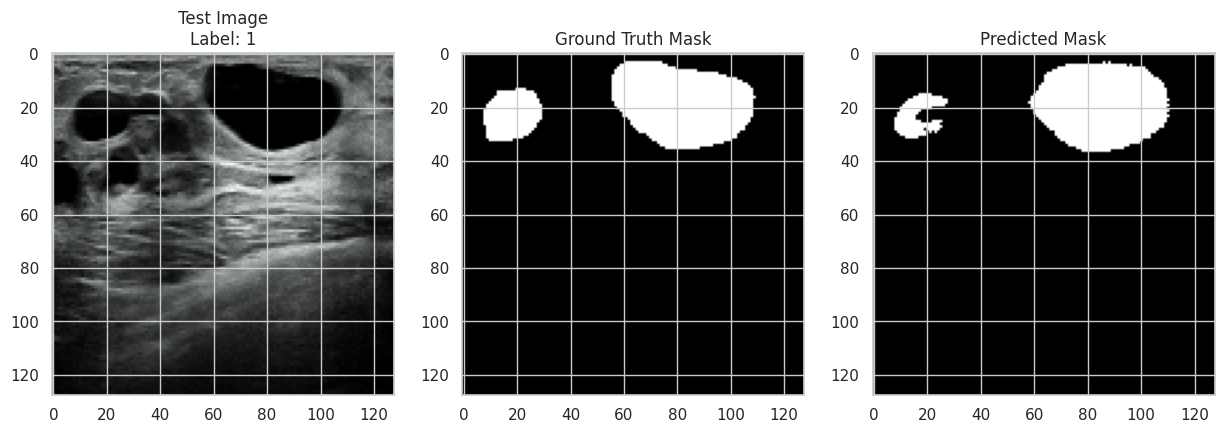

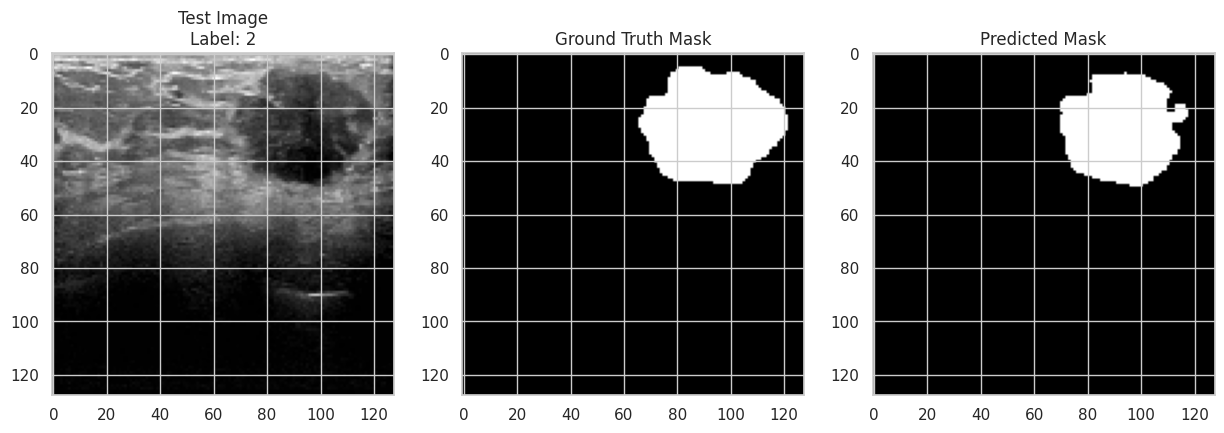

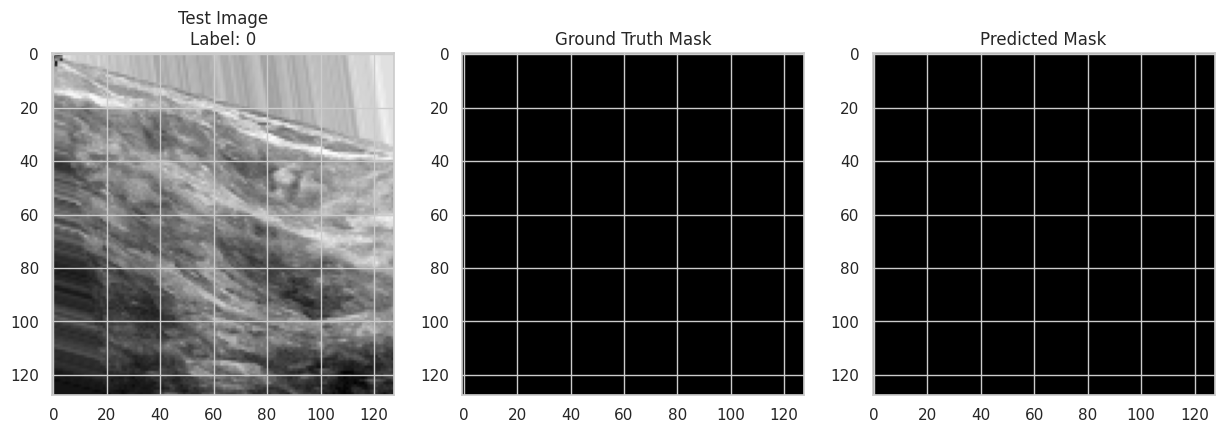

In [ ]:
# Visualize some of the test images, ground truth masks, and predicted masks
num_samples_to_visualize = 5

visualize_results_unet(X_test_image, test_masks, preds_test_mask, test_labels, num_samples=num_samples_to_visualize)

### **Image Classification - Transfer Learning**

To execute image classification of the ultrasound image data set, a transfer learning approach is adopted, leveraging the ResNet50 architecture as the foundational backbone. This involves incorporating additional dense layers to fine-tune the convolutional neural network using the training dataset.

Transfer learning is a machine learning technique where a pre-trained model (in this case, ResNet50) is employed as the starting point for training a new model on a specific task. This approach capitalizes on the knowledge gained by the pre-trained model on a large dataset and adapts it to our spectifc task with a smaller dataset of ultrasound images, enhancing the efficiency of the training process.

The inputs for the model training process include the origin ultrasound images, LBP-images, HOG-images, and the predicted masks generated by the U-Net. The inclusion of these diverse representations of the origin images enriches the training process by providing the model with a comprehensive set of features, enabling it to discern nuanced patterns.







In [ ]:
# To get the best results from the ResNet50 the images and masks need to be resized to (197,197)

X_train_image_resized, X_train_lbp_resized, X_train_hog_resized, preds_train_mask_resized = resize_images_and_masks(
    X_train_image, X_train_lbp, X_train_hog, preds_train_mask)

X_test_image_resized, X_test_lbp_resized, X_test_hog_resized, preds_test_mask_resized = resize_images_and_masks(
    X_test_image, X_test_lbp, X_test_hog, preds_test_mask)

# Verify the shapes
print("X_train_image_resized shape:", X_train_image_resized.shape)
print("X_train_lbp_resized shape:", X_train_lbp_resized.shape)
print("X_train_hog_resized shape:", X_train_hog_resized.shape)
print("preds_train_mask_resized shape:", preds_train_mask_resized.shape)

X_train_image_resized shape: (715, 197, 197, 3)
X_train_lbp_resized shape: (715, 197, 197, 1)
X_train_hog_resized shape: (715, 197, 197, 1)
preds_train_mask_resized shape: (715, 197, 197, 1)


In [ ]:
# three classes: normal, benign, malignant
num_classes = 3

# Convert labels to one-hot encoding for categorical_crossentropy loss
train_labels_encoded = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)
test_labels_encoded = tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)

In [ ]:
# Defining input layers including the original image, LBP-image, HOG-image, and predicted mask from the U-net
image_shape = (197, 197, 3)
lbp_shape = (197, 197, 1)
hog_shape = (197, 197, 1)
mask_shape = (197, 197, 1)

# Define input layers for each type of data
inputs_image = Input(shape=image_shape, name='image_input')
inputs_lbp = Input(shape=lbp_shape, name='lbp_input')
inputs_hog = Input(shape=hog_shape, name='hog_input')
inputs_mask = Input(shape=mask_shape, name='mask_input')

# Applying the preprocess_input function from keras to the original images as this is recommended to get best result from ResNet50
X_train_image_processed = preprocess_input(X_train_image_resized)
X_test_image_processed = preprocess_input(X_test_image_resized)

# Flatten the LBP and HOG inputs
flattened_lbp = GlobalAveragePooling2D()(inputs_lbp)
flattened_hog = GlobalAveragePooling2D()(inputs_hog)
flattened_mask = GlobalAveragePooling2D()(inputs_mask)


In [ ]:
# Defining the convolutional neural network

# Add ResNet-50 base
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=image_shape)
resnet_base.trainable = False
resnet_output = resnet_base(inputs_image)
resnet_output = GlobalAveragePooling2D()(resnet_output)  # Use Global Average Pooling to reduce dimensions

# Concatenate the outputs from ResNet-50, LBP, HOG, and mask
concatenated = Concatenate()([resnet_output, flattened_lbp, flattened_hog, flattened_mask])

# Custom layers with dense and dropout layers
x = Dense(32, activation='relu')(concatenated)
x = Dropout(0.1)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)

# Output layer with softmax activation for multiclass classification
output_layer = Dense(num_classes, activation='softmax')(x)

In [ ]:
# Create the model
model = Model(inputs=[inputs_image, inputs_lbp, inputs_hog, inputs_mask], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical crossentropy for multiclass problems
              metrics=['accuracy'])

# Summary
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 197, 197, 3)]        0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['image_input[0][0]']         
                                                          2                                       
                                                                                                  
 lbp_input (InputLayer)      [(None, 197, 197, 1)]        0         []                            
                                                                                                  
 hog_input (InputLayer)      [(None, 197, 197, 1)]        0         []                      

In [ ]:
# Define callbacks for the training process
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_ccn_model.h5', verbose = 1, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

In [ ]:
# Train the model with the defined architecture and callbacks
history = model.fit(
    [X_train_image_processed, X_train_lbp_resized, X_train_hog_resized, preds_train_mask_resized],
    train_labels_encoded,
    validation_split=0.1,
    batch_size=batch_size,
    epochs = 100,
    callbacks=callbacks
    )

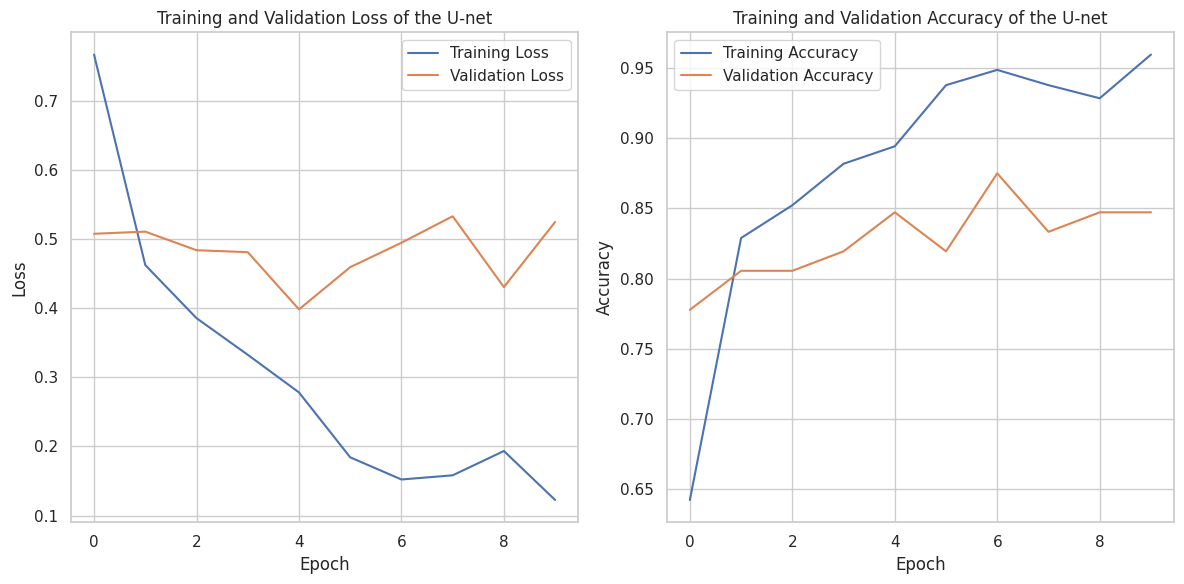

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss of the U-net')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy of the U-net')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

6/6 [==============================] - 30s 5s/step
Accuracy on Test Set: 0.8435754189944135
Classification Report on Test Set:               precision    recall  f1-score   support

           0       0.84      0.98      0.91        59
           1       0.80      0.82      0.81        60
           2       0.90      0.73      0.81        60

    accuracy                           0.84       179
   macro avg       0.85      0.84      0.84       179
weighted avg       0.85      0.84      0.84       179



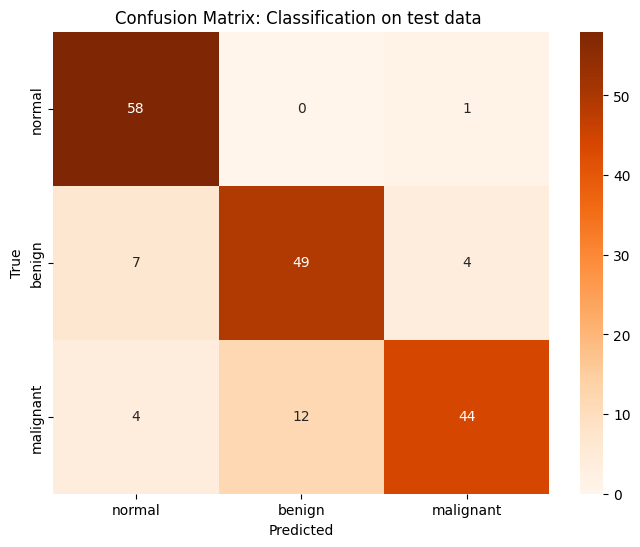

In [ ]:
# Evaluation the trained classification model on the test data set
preds_cnn = model.predict([X_test_image_processed, X_test_lbp_resized, X_test_hog_resized, preds_test_mask_resized], verbose =1)

# Convert predictions to class labels
predicted_classes = np.argmax(preds_cnn, axis=1)

# Convert one-hot encoded labels to categorical labels
test_labels_categorical = np.argmax(test_labels_encoded, axis=1)

# Evaluation metrics for classification task
accuracy_test = accuracy_score(test_labels_categorical, predicted_classes)
classification_result = classification_report(test_labels_categorical, predicted_classes)
confusion = confusion_matrix(test_labels_categorical, predicted_classes)

print("Accuracy on Test Set:", accuracy_test)
print("Classification Report on Test Set:", classification_result)

# Create a heatmap for visualization of the confusion matrix
categories = {'normal':0, 'benign':1, 'malignant':2}

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Oranges', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix: Classification on test data ')
plt.show()


In [ ]:
# Comparing the the classification results from the baseline model SVM (predicare_part_1 notebook) and the transfer learning

comparison = {
    'Metric': ['Accuracy', 'F1-Score: normal', 'F1-Score: benign', 'F1-Score: malignant'],
    'Baseline Model': [0.64, 0.26, 0.75, 0.48],
    'Transfer Learning': [0.84, 0.91, 0.81, 0.81]
}

# Create a DataFrame
df = pd.DataFrame(comparison).set_index('Metric')

# Display the DataFrame as a table
df

,Baseline Model,Transfer Learning
Metric,,
Accuracy,0.64,0.84
F1-Score: normal,0.26,0.91
F1-Score: benign,0.75,0.81
F1-Score: malignant,0.48,0.81



When assessing the performance of our baseline model from the "predicare_part_1" notebook against the transfer learning approach, notable improvements are observed. The accuracy achieved through transfer learning significantly surpasses that of the baseline model. Additionally, the F1 scores across the three classes — normal, benign, and malignant — demonstrate a considerable enhancement, reinforcing the efficacy of transfer learning in capturing intricate patterns within the ultrasound images and contributing to superior classification results.